The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
%%capture

import sys
sys.path.append('..')
import mock_d2l_jax as d2l

# Object-Oriented Design for Implementation
:label:`sec_oo-design`

In our introduction to linear regression,
we walked through various components
including
the data, the model, the loss function,
and the optimization algorithm.
Indeed,
linear regression is
one of the simplest machine learning models.
Training it,
however, uses many of the same components as other models in this book require.
Therefore, 
before diving into the implementation details
it is worth 
designing some of the APIs
used throughout this book. 
Treating components in deep learning
as objects,
we can start by
defining classes for these objects
and their interactions.
This object-oriented design
for implementation
will greatly
streamline the presentation and you might even want to use it in your projects.


Inspired by open-source libraries such as [PyTorch Lightning](https://www.pytorchlightning.ai/),
on a high level
we wish to have three classes: 
(i) `Module` contains models, losses, and optimization methods; 
(ii) `DataModule` provides data loaders for training and validation; 
(iii) both classes are combined using the `Trainer` class, which allows us to
train models on a variety of hardware platforms. 
Most code in this book adapts `Module` and `DataModule`. We will touch upon the `Trainer` class only when we discuss GPUs, CPUs, parallel training, and optimization algorithms.


In [2]:
import time
import numpy as np

import jax
from jax import numpy as jnp, random, grad, vmap, jit
from flax import linen as nn
from flax.training.train_state import TrainState
import optax

import tensorflow as tf
import tensorflow_datasets as tfds

# from d2l import jax as d2l

## Utilities
:label:`oo-design-utilities`

We need a few utilities to simplify object-oriented programming in Jupyter notebooks. One of the challenges is that class definitions tend to be fairly long blocks of code. Notebook readability demands short code fragments, interspersed with explanations, a requirement incompatible with the style of programming common for Python libraries. The first
utility function allows us to register functions as methods in a class *after* the class has been created. In fact, we can do so *even after* we've created instances of the class! It allows us to split the implementation of a class into multiple code blocks.


In [3]:
def add_to_class(Class):  #@save
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

Let's have a quick look at how to use it. We plan to implement a class `A` with a method `do`. Instead of having code for both `A` and `do` in the same code block, we can first declare the class `A` and create an instance `a`.


In [4]:
class A:
    def __init__(self):
        self.b = 1

a = A()

Next we define the method `do` as we normally would, but not in class `A`'s scope. Instead, we decorate this method by `add_to_class` with class `A` as its argument. In doing so, the method is able to access the member variables of `A` as we would expect if it had been defined as part of `A`'s definition. Let's see what happens when we invoke it for the instance `a`.


In [5]:
@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1


The second one is a utility class that saves all arguments in a class's `__init__` method as class attributes. This allows us to extend constructor call signatures implicitly without additional code.


In [6]:
class HyperParameters:  #@save
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

We defer its implementation into :numref:`sec_utils`. To use it, we define our class that inherits from `HyperParameters` and calls `save_hyperparameters` in the `__init__` method.


In [7]:
# Call the fully implemented HyperParameters class saved in d2l
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


The last utility allows us to plot experiment progress interactively while it is going on. In deference to the much more powerful (and complex) [TensorBoard](https://www.tensorflow.org/tensorboard) we name it `ProgressBoard`. The  implementation is deferred to :numref:`sec_utils`. For now, let's simply see it in action.

The `draw` function plots a point `(x, y)` in the figure, with `label` specified in the legend. The optional `every_n` smooths the line by only showing $1/n$ points in the figure. Their values are averaged from the $n$ neighbor points in the original figure.


In [8]:
class ProgressBoard(d2l.HyperParameters):  #@save
    """Plot data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

In the following example, we draw `sin` and `cos` with a different smoothness. If you run this code block, you will see the lines grow in animation.


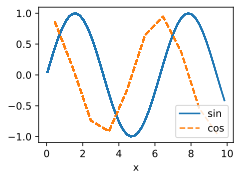

In [9]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

## Models
:label:`oo-design-models`

The `Module` class  is the base class of all models we will implement. At a minimum we need to define three methods. The `__init__` method stores the learnable parameters, the `training_step` method accepts a data batch to return the loss value, the `configure_optimizers` method returns the optimization method, or a list of them, that is used to update the learnable parameters. Optionally we can define `validation_step` to report the evaluation measures.
Sometimes we put the code to compute the output into a separate `forward` method to make it more reusable.


In [10]:
class Module(nn.Module):
    """Defined in :numref:`sec_oo-design`"""

    plot_train_per_epoch: int = 2
    plot_valid_per_epoch: int = 1
    board: ProgressBoard = ProgressBoard()
    training: bool = None

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, "net"), "Neural network is defined"
        return self.net(X)

    def __call__(self, X, *args, **kwargs):
        if kwargs and "training" in kwargs:
            self.training = kwargs["training"]
        return self.forward(X, *args)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, "trainer"), "Trainer is not inited"
        self.board.xlabel = "epoch"
        if train:
            x = self.trainer.train_batch_idx / self.trainer.num_train_batches
            n = self.trainer.num_train_batches / self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / self.plot_valid_per_epoch

        self.board.draw(x, value, ("train_" if train else "val_") + key, every_n=int(n))

    def training_step(self, params, batch):
        loss, grads = jax.value_and_grad(self.loss)(params, *batch[:-1], batch[-1])
        self.plot("loss", loss, train=True)
        return loss, grads

    def validation_step(self, params, batch):
        loss = self.loss(params, *batch[:-1], batch[-1])
        self.plot("loss", loss, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

    def configure_optimizers(self):
        """Defined in :numref:`sec_classification`"""
        return optax.sgd(learning_rate=self.lr)

You may notice that `Module` is a subclass of `nn.Module`, the base class of neural networks in PyTorch.
It provides convenient features to handle neural networks. For example, if we define a `forward` method, such as `forward(self, X)`, then for an instance `a` we can invoke this function by `a(X)`. This works since it calls the `forward` method in the built-in `__call__` method. You can find more details and examples about `nn.Module` in :numref:`sec_model_construction`.


##  Data
:label:`oo-design-data`

The `DataModule` class is the base class for data. Quite frequently the `__init__` method is used to prepare the data. This includes downloading and preprocessing if needed. The `train_dataloader` returns the data loader for the training dataset. A data loader is a (Python) generator that yields a data batch each time it is used. This batch is then fed into the `training_step` method of `Module` to compute the loss. There is an optional `val_dataloader` to return the validation dataset loader. It behaves in the same manner, except that it yields data batches for the `validation_step` method in `Module`.


In [11]:
class DataModule(HyperParameters):
    """Defined in :numref:`sec_oo-design`"""

    def __init__(self, root="../data"):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        """Defined in :numref:`sec_synthetic-regression-data`"""
        tensors = tuple(a[indices] for a in tensors)
        shuffle_buffer = tensors[0].shape[0] if train else 1
        return tfds.as_numpy(
            tf.data.Dataset.from_tensor_slices(tensors)
            .shuffle(buffer_size=shuffle_buffer)
            .batch(self.batch_size)
        )

## Training
:label:`oo-design-training`

The `Trainer` class trains the learnable parameters in the `Module` class with data specified in `DataModule`. The key method is `fit`, which accepts two arguments: `model`, an instance of `Module`, and `data`, an instance of `DataModule`. It then iterates over the entire dataset `max_epochs` times to train the model. As before, we will defer the implementation of this function to later chapters.


In [12]:
class Trainer(HyperParameters):
    """Defined in :numref:`sec_oo-design`"""

    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, "No GPU support yet"

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (
            len(self.val_dataloader) if self.val_dataloader is not None else 0
        )

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, params, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.state = TrainState.create(
            apply_fn=model.apply, params=params, tx=model.configure_optimizers()
        )

        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def prepare_batch(self, batch):
        """Defined in :numref:`sec_linear_scratch`"""
        return batch

    def fit_epoch(self):
        """Defined in :numref:`sec_linear_scratch`"""
        self.model.training = True

        for batch in self.train_dataloader:
            _, grads = self.model.training_step(
                self.state.params, self.prepare_batch(batch)
            )

            # todo: clip
            # if self.gradient_clip_val > 0:
            #     grads = self.clip_gradients(self.gradient_clip_val, grads)

            self.state = self.state.apply_gradients(grads=grads)
            self.train_batch_idx += 1

        if self.val_dataloader is None:
            return

        self.model.training = False
        for batch in self.val_dataloader:
            self.model.validation_step(self.state.params, self.prepare_batch(batch))
            self.val_batch_idx += 1

    # todo: clip
    # def clip_gradients(self, grad_clip_val, grads):
    #     """Defined in :numref:`sec_rnn-scratch`"""
    #     grad_clip_val = tf.constant(grad_clip_val, dtype=tf.float32)
    #     new_grads = [tf.convert_to_tensor(grad) if isinstance(
    #         grad, tf.IndexedSlices) else grad for grad in grads]
    #     norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)) for grad in new_grads))
    #     if tf.greater(norm, grad_clip_val):
    #         for i, grad in enumerate(new_grads):
    #             new_grads[i] = grad * grad_clip_val / norm
    #         return new_grads
    #     return grads

## Summary

To highlight the object-oriented design
for our future deep learning implementation,
the above classes just show how their objects 
store data and interact with each other.
We will keep enriching implementations of these classes,
such as via `@add_to_class`,
in the rest of the book.
Moreover,
these fully implemented classes
are saved in the [d2l library](https://github.com/d2l-ai/d2l-en/tree/master/d2l),
a *lightweight toolkit* that makes structured modeling for deep learning easy. 
In particular, it facilitates reusing many components between projects without changing much at all. For instance, we can replace just the optimizer, just the model, just the dataset, etc.;
this degree of modularity pays dividends throughout the book in terms of conciseness and simplicity (this is why we added it) and it can do the same for your own projects. 


## Exercises

1. Locate full implementations of the above classes that are saved in the [d2l library](https://github.com/d2l-ai/d2l-en/tree/master/d2l). We strongly recommend that you look at the implementation in detail once you have gained some more familiarity with deep learning modeling.
1. Remove the `save_hyperparameters` statement in the `B` class. Can you still print `self.a` and `self.b`? Optional: if you have dived into the full implementation of the `HyperParameters` class, can you explain why?


[Discussions](https://discuss.d2l.ai/t/6646)
